In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
from corner import corner

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.utils import util

In [2]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass_full')
detectable_halos = util.unpickle_all(save_dir, 'detectable_halos_', '.pkl')

z_list, m_list, c_list = [], [], []

for halo_list in detectable_halos:
    for z, m, c in halo_list:
        z_list.append(z)
        m_list.append(m)
        c_list.append(c)

m_list = [np.log10(m) for m in m_list]

In [3]:
# np.log10(1.9*1e8)

In [4]:
hst_masses = [11.91, 11.12, 11.75, 11.95, 8.65]
hst_zs = [0.2219, 0.2270, 0.1045, 0.4980, 0.5628]

roman_masses = m_list
roman_zs = z_list

In [5]:
# f, ax1 = plt.subplots(figsize=(3.5, 3.5))
# ax1.hist(roman_masses, bins=20, alpha=0.5, label='Roman', histtype='step', weights=plot_util.weights(roman_masses))
# ax1.hist(hst_masses, bins=20, alpha=0.5, label='HST', histtype='step', weights=plot_util.weights(hst_masses))
# ax1.set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# ax1.set_ylabel('Probability Density')

# ax2 = ax1.twiny()
# ax2.hist(roman_zs, bins=20, alpha=0.5, label='Roman', weights=plot_util.weights(roman_zs))
# ax2.hist(hst_zs, bins=20, alpha=0.5, label='HST', weights=plot_util.weights(hst_zs))
# ax2.set_xlabel('Subhalo Redshift')

# plt.legend()
# plt.show()

In [6]:
q_low = 0.16
q_mid = 0.5
q_high = 0.84

roman_masses_q = np.quantile(roman_masses, [q_low, q_mid, q_high])
hst_masses_q = np.quantile(hst_masses, [q_low, q_mid, q_high])
roman_zs_q = np.quantile(roman_zs, [q_low, q_mid, q_high])
hst_zs_q = np.quantile(hst_zs, [q_low, q_mid, q_high])

roman_mass_high = roman_masses_q[2] - roman_masses_q[1]
roman_mass_low = roman_masses_q[1] - roman_masses_q[0]
hst_mass_high = hst_masses_q[2] - hst_masses_q[1]
hst_mass_low = hst_masses_q[1] - hst_masses_q[0]
roman_z_high = roman_zs_q[2] - roman_zs_q[1]
roman_z_low = roman_zs_q[1] - roman_zs_q[0]
hst_z_high = hst_zs_q[2] - hst_zs_q[1]
hst_z_low = hst_zs_q[1] - hst_zs_q[0]

print(f'{roman_masses_q[1]:.2f} +{roman_mass_high:.2f} -{roman_mass_low:.2f}')
print(f'{hst_masses_q[1]:.2f} +{hst_mass_high:.2f} -{hst_mass_low:.2f}')
print(f'{roman_zs_q[1]:.2f} +{roman_z_high:.2f} -{roman_z_low:.2f}')
print(f'{hst_zs_q[1]:.2f} +{hst_z_high:.2f} -{hst_z_low:.2f}')

11.39 +0.44 -0.73
11.75 +0.17 -1.52
0.37 +0.20 -0.17
0.23 +0.29 -0.05


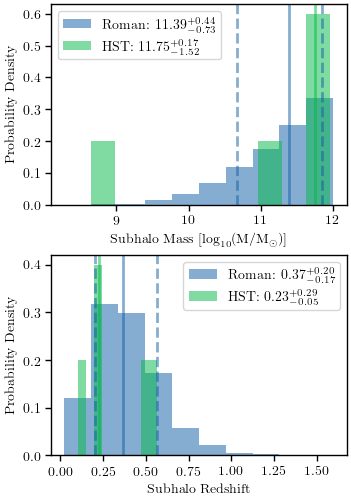

In [7]:
f, ax = plt.subplots(2, 1, figsize=(3.5, 5), constrained_layout=True)

ax[0].hist(roman_masses, alpha=0.5, label=f'Roman: {roman_masses_q[1]:.2f}' + r'$\substack{+0.44 \\ -0.73}$', weights=plot_util.weights(roman_masses))
ax[0].hist(hst_masses, alpha=0.5, label=f'HST: {hst_masses_q[1]:.2f}' + r'$\substack{+0.17 \\ -1.52}$', weights=plot_util.weights(hst_masses))
ax[0].axvline(roman_masses_q[0], color='C0', linestyle='--', alpha=0.5)
ax[0].axvline(roman_masses_q[1], color='C0', linestyle='-', alpha=0.5)
ax[0].axvline(roman_masses_q[2], color='C0', linestyle='--', alpha=0.5)
ax[0].axvline(hst_masses_q[1], color='C1', linestyle='-', alpha=0.5)
ax[0].set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax[0].set_ylabel('Probability Density')
ax[0].legend()

ax[1].hist(roman_zs, alpha=0.5, label=f'Roman: {roman_zs_q[1]:.2f}' + r'$\substack{+0.20 \\ -0.17}$', weights=plot_util.weights(roman_zs))
ax[1].hist(hst_zs, alpha=0.5, label=f'HST: {hst_zs_q[1]:.2f}' + r'$\substack{+0.29 \\ -0.05}$', weights=plot_util.weights(hst_zs))
ax[1].axvline(roman_zs_q[0], color='C0', linestyle='--', alpha=0.5)
ax[1].axvline(roman_zs_q[1], color='C0', linestyle='-', alpha=0.5)
ax[1].axvline(roman_zs_q[2], color='C0', linestyle='--', alpha=0.5)
ax[1].axvline(hst_zs_q[1], color='C1', linestyle='-', alpha=0.5)
ax[1].set_xlabel('Subhalo Redshift')
ax[1].set_ylabel('Probability Density')
ax[1].legend()

plt.savefig(os.path.join(figure_dir, 'subhalo_detection_compare.png'))
plt.show()

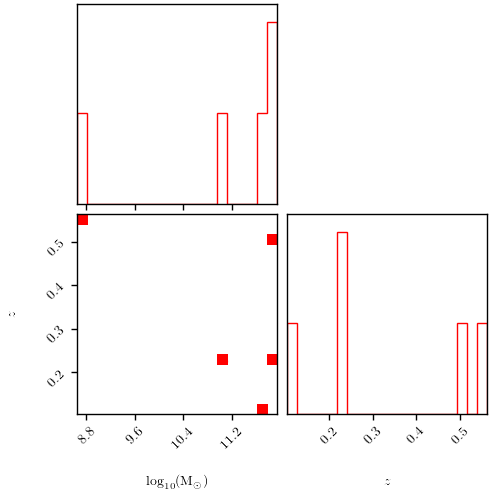

In [88]:
hst_detections = np.column_stack([hst_masses, hst_zs])

hst = corner(hst_detections, labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'], color='r')

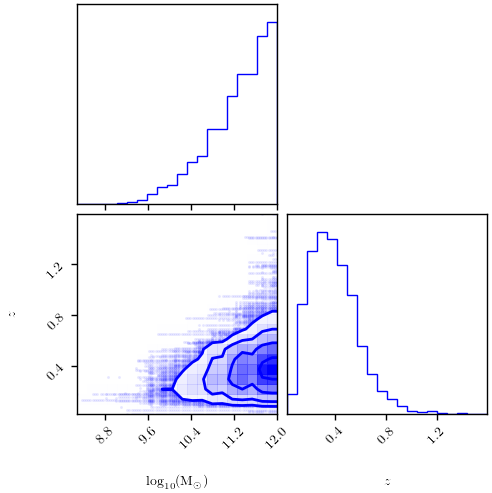

In [89]:
roman_detections = np.column_stack([roman_masses, roman_zs])

roman = corner(roman_detections, color='b', labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'])

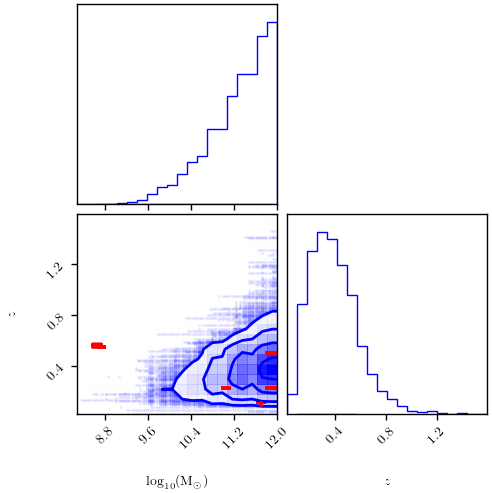

In [90]:
corner(hst_detections, labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'], color='r', fig=roman)